# Reconstruction test for ABC object

various methods to reconstruct the data into python objects.  

## Setup

In [1]:
import os
import numpy as np
import platform
import pandas as pd
import cx_Oracle as odb
import matplotlib.pyplot as plt
import pandas.io.sql as psql
import array

In [2]:
# working dir
if platform.system() == 'Windows':
    os.chdir(os.path.join(os.getenv('HOME'),'Documents', 'Development', 'dst', 'examples', 'abc_db'))
else:
    os.chdir(os.path.join(os.getenv('DST'),'examples', 'abc_db'))
print(os.getcwd())

# plots 
%matplotlib inline
np.set_printoptions(precision=4)
plt.rc('figure', figsize=(10, 8))

/Users/rwk7t/Development/dst/examples/abc_db


test connections:

In [3]:
# Build connection string
user     = "abc"
sid      = "XE" if platform.system()=='Windows' else "ORCL"
pswd     = "abc"
conn_str =" %s/%s@%s" % (user, pswd, sid)

# Connect to Oracle and test
conn = odb.connect(user, pswd, sid)
if (conn):
    print("Connection successful")
    print(conn.version)
else:
    print("Connection not successful")

conn.close()

Connection successful
12.1.0.2.0


## test image blob

In [37]:
#%%timeit -n 1
try:
    conn = odb.connect(user, pswd, sid)
    sql = """
select
    t.pic1.ndim
  , t.pic1.dim1
  , t.pic1.dim2
  , t.pic1.dim3
  , t.pic1.value
from teams t
where name='team2'
"""
        
    cursor = conn.cursor()
    cursor.execute(sql)
    record = cursor.fetchone()
    print(record)
    
except odb.DatabaseError, exc:
    print(exc)
finally:
    cursor.close()

(3, 183, 275, 3, <cx_Oracle.LOB object at 0x1135dfdb0>)


In [38]:
#%%timeit -n 1
ndim   = record[0]
dim1   = record[1]
dim2   = record[2]
dim3   = record[3]
blob   = record[4]
blob_image = np.array(array.array('B', blob.read()), dtype=np.uint8).reshape((dim1, dim2, dim3))
blob_image.shape

(183, 275, 3)

(183, 275, 3)
150975
150975


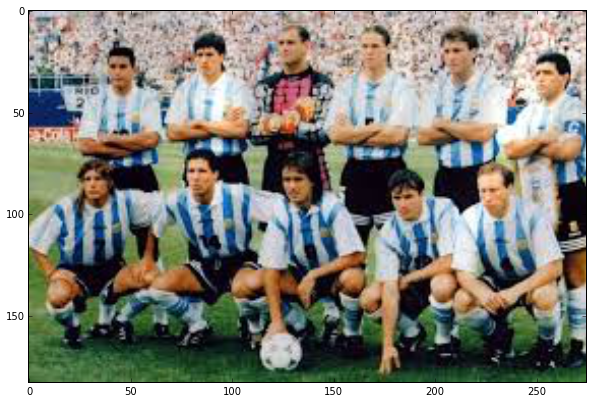

In [39]:
plt.imshow(blob_image)
print(blob_image.shape)
print(blob_image.size)
print(dim1*dim2*dim3)

## 2nd attempt at a UI

#### Connect to DB:

In [40]:
conn = odb.connect(user, pswd, sid)

#### Helper Classes:

In [41]:
np.array([7.8]).dtype

dtype('float64')

In [42]:
def GetDataType(dtype):
    if   dtype=='string'     : return np.bool;
    elif dtype=='uint8'      : return np.uint8;
    elif dtype=='uint16'     : return np.uint16;
    elif dtype=='uint32'     : return np.uint32;
    elif dtype=='uint64'     : return np.uint64;
    elif dtype=='int8'       : return np.int8;
    elif dtype=='int16'      : return np.int16;
    elif dtype=='int32'      : return np.int32;
    elif dtype=='int64'      : return np.int64;
    elif dtype=='float16'    : return np.float16;
    elif dtype=='float32'    : return np.float32;
    elif dtype=='float64'    : return np.float64;
    elif dtype=='float128'   : return np.float128;
    elif dtype=='complex64'  : return np.complex64;
    elif dtype=='complex128' : return np.complex128;
    elif dtype=='complex256' : return np.complex256;
    else:
        raise ValueError('%s is not a valid type' % dtype)

GetDataType('uint64')

numpy.uint64

In [33]:
class ColumnAttributes(object):
    
    def __init__(self, table_name, column_name, oracle_type, precision, scale):
      
        if   oracle_type == 'NUMBER' and precision == 0:
            python_type = 'int''
        elif oracle_type == 'NUMBER' and precision != 0:
            python_type = 'float'
        elif oracle_type == 'VARCHAR2':
            python_type = 'str'
        elif oracle_type == 'ARRAYINFO':
            python_type = 'ArrayInfo'
        else:
            raise ValueError('%s is not supported' % oracle_type)
        
        self.oracle_type = oracle_type
        self.python_type = python_type
        self.table_name  = table_name
        self.column_name = column_name

In [36]:
def GetColumnAttributes(conn, table_name):
    
    sql = """\
select 
    column_name
  , data_type
  , data_precision
  , data_scale
from
  user_tab_columns
where
  table_name = '%s'
""" % table_name.upper()
    columns_dict = psql.read_sql(sql, conn).to_dict()
    
    columns = {}
    for k, v in columns_dict.items():
        columns[k] = ColumnAttribues(v['table_name'], v[''])
        
    return df   

df = GetColumnAttributes(conn, "PLAYERS")
df

{'COLUMN_NAME': {0: 'IMAGE3',
  1: 'IMAGE2',
  2: 'IMAGE1',
  3: 'TEAMS_ID',
  4: 'GOALS',
  5: 'STARTS',
  6: 'NAME',
  7: 'ID'},
 'DATA_PRECISION': {0: nan,
  1: nan,
  2: nan,
  3: 7.0,
  4: nan,
  5: nan,
  6: nan,
  7: 7.0},
 'DATA_SCALE': {0: nan,
  1: nan,
  2: nan,
  3: 0.0,
  4: nan,
  5: nan,
  6: nan,
  7: 0.0},
 'DATA_TYPE': {0: 'ARRAYINFO',
  1: 'ARRAYINFO',
  2: 'ARRAYINFO',
  3: 'NUMBER',
  4: 'NUMBER',
  5: 'NUMBER',
  6: 'VARCHAR2',
  7: 'NUMBER'}}

In [10]:
class ArrayHandle(object):
    
    def __init__(self, conn, table_name, col_name, row_id):
        self.conn = conn
        self.table_name = table_name
        self.col_name = col_name
        self.row_id = row_id
        self.value = None
        
    def IsLoaded(self):
        return (self.value is not None)
    
    def Load(self):
        
        # build query
        sql = """
select
      t.%s.ndim 
    , t.%s.dim1 
    , t.%s.dim2 
    , t.%s.dim3 
    , t.%s.dim4 
    , t.%s.dtype
    , t.%s.value 
from %s t where t.id=%d
""" %   (
            self.col_name, 
            self.col_name, 
            self.col_name, 
            self.col_name, 
            self.col_name, 
            self.col_name,
            self.col_name,
            self.table_name, 
            self.row_id
        )
        
        # load
        try:
            cursor = self.conn.cursor()
            cursor.execute(sql)
            record = cursor.fetchone()

            # reconstruct array
            ndim   = record[0]
            dim1   = record[1]
            dim2   = record[2]
            dim3   = record[3]
            dim4   = record[4]
            dtype  = GetDataType(record[5])
            blob   = record[6]
            value  = np.array(array.array('B', blob.read()), dtype=dtype)
            if   ndim == 1: value = value.reshape((dim1,))
            elif ndim == 2: value = value.reshape((dim1,dim2))
            elif ndim == 3: value = value.reshape((dim1,dim2,dim3))
            elif ndim == 4: value = value.reshape((dim1,dim2,dim3,dim4))
            else: value = None
            self.value = value

        # TODO: think about this part.. 
        except odb.DatabaseError, exc:
            print(exc)
        except:
            print('some other error')
        finally:
            cursor.close()
    
    def Clear(self):
        self.value = None
        
    def Get(self):
        if not self.IsLoaded():
            self.Load()
        return self.value
    
h = ArrayHandle(conn, "players", "image2", 1)
print(h.value)
h.Load()
print(h.IsLoaded())
print(h.value.shape)
h.Clear()
print(h.IsLoaded())
print(h.value)
print(h.Get().shape)
print(h.IsLoaded())

None
True
(500, 331, 3)
False
None
(500, 331, 3)
True


#### Class for player

Player {
    name: t1p1
    team: team1
    id: 1
    goals: 7
    starts: 12
    image1: ArrayInfo{avg: 108.5904, std: 43.8245, dtype: not loaded, shape:    not loaded}
    image2: ArrayInfo{avg: 155.9964, std: 72.8447, dtype: not loaded, shape:    not loaded}
    image3: ArrayInfo{avg: 142.0293, std: 52.1584, dtype: not loaded, shape:    not loaded}
}
Player {
    name: t1p1
    team: team1
    id: 1
    goals: 7
    starts: 12
    image1: ArrayInfo{avg: 108.5904, std: 43.8245, dtype:      uint8, shape: (743, 508, 3)}
    image2: ArrayInfo{avg: 155.9964, std: 72.8447, dtype:      uint8, shape: (500, 331, 3)}
    image3: ArrayInfo{avg: 142.0293, std: 52.1584, dtype:      uint8, shape: (606, 425, 3)}
}
Player {
    name: t1p1
    team: team1
    id: 1
    goals: 7
    starts: 12
    image1: ArrayInfo{avg: 108.5904, std: 43.8245, dtype: not loaded, shape:    not loaded}
    image2: ArrayInfo{avg: 155.9964, std: 72.8447, dtype: not loaded, shape:    not loaded}
    image3: ArrayInfo{avg:

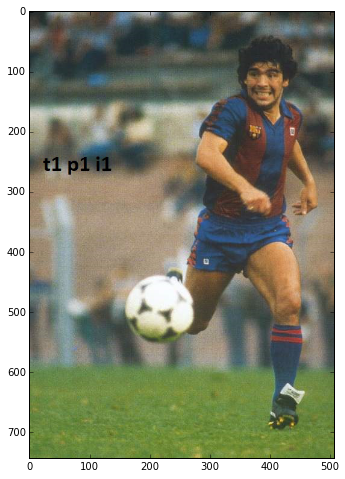

Player {
    name: t1p1
    team: team1
    id: 1
    goals: 7
    starts: 12
    image1: ArrayInfo{avg: 108.5904, std: 43.8245, dtype:      uint8, shape: (743, 508, 3)}
    image2: ArrayInfo{avg: 155.9964, std: 72.8447, dtype: not loaded, shape:    not loaded}
    image3: ArrayInfo{avg: 142.0293, std: 52.1584, dtype: not loaded, shape:    not loaded}
}


In [12]:
class Player(object):
    
    def __init__(self, conn, player_id):
        
        try:
            sql = """
select p.id
    , p.name
    , p.goals
    , p.starts
    , p.teams_id
    , t.name
from players p inner join teams t on p.teams_id=t.id
where p.id=%d""" % player_id
            cursor = conn.cursor()
            cursor.execute(sql)
            record = cursor.fetchone()
            
        except odb.DatabaseError, exc:
            print(exc)
        
        finally:
            cursor.close()
        
        self.id      = record[0]
        self.name    = record[1]
        self.goals   = record[2]
        self.starts  = record[3]
        self.image1  = ArrayInfo(conn, "players", "image1", self.id)
        self.image2  = ArrayInfo(conn, "players", "image2", self.id)
        self.image3  = ArrayInfo(conn, "players", "image3", self.id)
        self.team_id = record[4]
        self.team    = record[5]
    
    def __str__(self):
        result = """Player {
    name: %s
    team: %s
    id: %d
    goals: %d
    starts: %d
    image1: %s
    image2: %s
    image3: %s
}""" % \
        (
            self.name,
            self.team,
            self.id, 
            self.goals, 
            self.starts,
            str(self.image1),
            str(self.image2),
            str(self.image3),
        )
        return result
    
    def __repr__(self):
        return self.__str__()
    
    def Load(self):
        self.image1.Load()
        self.image2.Load()
        self.image3.Load()
    
    def Clear(self):
        self.image1.Clear()
        self.image2.Clear()
        self.image3.Clear()
    
p = Player(conn=conn, player_id=1)
print(p)
p.Load()
print(p)
p.Clear()
print(p)
plt.imshow(p.image1.Get())
plt.show()
print(p)

#### Class for the team

Team {
    name: team1
    id: 1
    wins: 7
    loses: 0
    pic1: ArrayInfo{avg: 124.0248, std: 65.1437, dtype: not loaded, shape:    not loaded}
    nplayers: 3
}
Team {
    name: team1
    id: 1
    wins: 7
    loses: 0
    pic1: ArrayInfo{avg: 124.0248, std: 65.1437, dtype:      uint8, shape: (417, 500, 3)}
    nplayers: 3
}
Team {
    name: team1
    id: 1
    wins: 7
    loses: 0
    pic1: ArrayInfo{avg: 124.0248, std: 65.1437, dtype: not loaded, shape:    not loaded}
    nplayers: 3
}


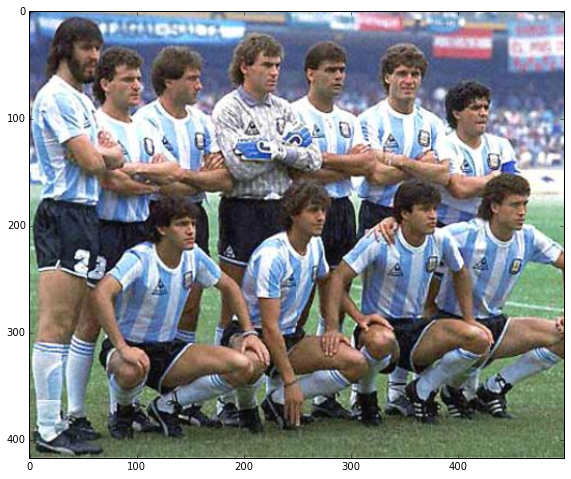

Team {
    name: team1
    id: 1
    wins: 7
    loses: 0
    pic1: ArrayInfo{avg: 124.0248, std: 65.1437, dtype:      uint8, shape: (417, 500, 3)}
    nplayers: 3
}


In [13]:
class Team(object):
    
    def __init__(self, conn, team_id):
        
        sql = """
select t.id
    , t.name
    , t.wins
    , t.loses
from teams t where t.id=%d
""" % team_id
        
        try:
            cursor = conn.cursor()
            cursor.execute(sql)
            record = cursor.fetchone()
            
        except odb.DatabaseError, exc:
            print(exc)
        
        finally:
            cursor.close()
        
        self.id    = record[0]
        self.name  = record[1]
        self.wins  = record[2]
        self.loses = record[3]
        self.pic1  = ArrayInfo(conn, "teams", "pic1", self.id)
        
        ## reconstruct players:
        try:
            sql = """
select p.id
from players p inner join teams t on p.teams_id=t.id
where t.id=%d""" % team_id
            cursor = conn.cursor()
            cursor.execute(sql)
            records = cursor.fetchall()
            
        except odb.DatabaseError, exc:
            print(exc)
        
        finally:
            cursor.close()
            
        self.players = [Player(conn, record[0]) for record in records]
        
    
    def __str__(self):
        result = """Team {
    name: %s
    id: %d
    wins: %d
    loses: %d
    pic1: %s
    nplayers: %d
}""" % (self.name, self.id, self.wins, self.loses, str(self.pic1), len(self.players))
        return result
    
    def __repr__(self):
        return self.__str__()
    
    def Load(self):
        self.pic1.Load()
        for p in self.players: p.Load()
    
    def Clear(self):
        self.pic1.Clear()
        for p in self.players: p.Clear()
    
t1 = Team(conn=conn, team_id=1)
print(t1)
t1.Load()
print(t1)
t1.Clear()
print(t1)
plt.imshow(t1.pic1.Get())
plt.show()
print(t1)

Player {
    name: t1p2
    team: team1
    id: 2
    goals: 0
    starts: 2
    image1: ArrayInfo{avg: 108.4242, std: 43.7371, dtype: not loaded, shape:    not loaded}
    image2: ArrayInfo{avg: 155.2595, std: 73.3658, dtype: not loaded, shape:    not loaded}
    image3: ArrayInfo{avg: 141.6368, std: 52.2845, dtype: not loaded, shape:    not loaded}
}


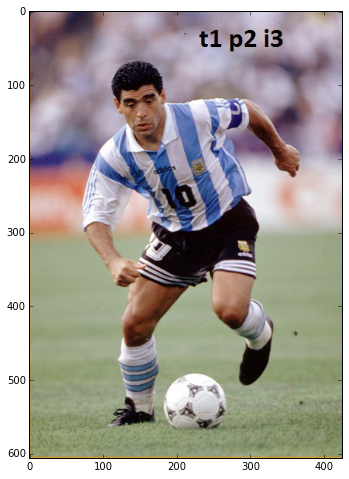

In [14]:
t1p2 = t1.players[1]
print(t1p2)
plt.imshow(t1p2.image3.Get())
plt.show()

#### UI for teams

In [15]:
def SelectTeams(conn, where = "", load=False):

    sql = """
select unique team_id 
from v_teams natural join v_players
"""
    if where != "":
        sql += "where %s" % where
        
    try:
        cursor = conn.cursor()
        cursor.execute(sql)
        records = cursor.fetchall()

    except odb.DatabaseError, exc:
        print(exc)

    finally:
        cursor.close()
        
    teams = [Team(conn, record[0]) for record in records]
    if load:
        for team in teams: team.Load()
            
    return teams

In [16]:
teams = SelectTeams(conn, where='team_wins<7')
print(teams)

[Team {
    name: team2
    id: 2
    wins: 2
    loses: 2
    pic1: ArrayInfo{avg: 120.2447, std: 74.2968, dtype: not loaded, shape:    not loaded}
    nplayers: 3
}]


In [17]:
teams = SelectTeams(conn, where='team_wins > 0 and player_goals > 9')
print(teams) 
print(teams[0].players)

[Team {
    name: team1
    id: 1
    wins: 7
    loses: 0
    pic1: ArrayInfo{avg: 124.0248, std: 65.1437, dtype: not loaded, shape:    not loaded}
    nplayers: 3
}, Team {
    name: team2
    id: 2
    wins: 2
    loses: 2
    pic1: ArrayInfo{avg: 120.2447, std: 74.2968, dtype: not loaded, shape:    not loaded}
    nplayers: 3
}]
[Player {
    name: t1p1
    team: team1
    id: 1
    goals: 7
    starts: 12
    image1: ArrayInfo{avg: 108.5904, std: 43.8245, dtype: not loaded, shape:    not loaded}
    image2: ArrayInfo{avg: 155.9964, std: 72.8447, dtype: not loaded, shape:    not loaded}
    image3: ArrayInfo{avg: 142.0293, std: 52.1584, dtype: not loaded, shape:    not loaded}
}, Player {
    name: t1p2
    team: team1
    id: 2
    goals: 0
    starts: 2
    image1: ArrayInfo{avg: 108.4242, std: 43.7371, dtype: not loaded, shape:    not loaded}
    image2: ArrayInfo{avg: 155.2595, std: 73.3658, dtype: not loaded, shape:    not loaded}
    image3: ArrayInfo{avg: 141.6368, std: 52.2

In [18]:
teams = SelectTeams(conn, where='80 < player_image1_avg and player_image1_avg < 150')
print(teams) 
print(teams[0].players)

[Team {
    name: team1
    id: 1
    wins: 7
    loses: 0
    pic1: ArrayInfo{avg: 124.0248, std: 65.1437, dtype: not loaded, shape:    not loaded}
    nplayers: 3
}, Team {
    name: team2
    id: 2
    wins: 2
    loses: 2
    pic1: ArrayInfo{avg: 120.2447, std: 74.2968, dtype: not loaded, shape:    not loaded}
    nplayers: 3
}]
[Player {
    name: t1p1
    team: team1
    id: 1
    goals: 7
    starts: 12
    image1: ArrayInfo{avg: 108.5904, std: 43.8245, dtype: not loaded, shape:    not loaded}
    image2: ArrayInfo{avg: 155.9964, std: 72.8447, dtype: not loaded, shape:    not loaded}
    image3: ArrayInfo{avg: 142.0293, std: 52.1584, dtype: not loaded, shape:    not loaded}
}, Player {
    name: t1p2
    team: team1
    id: 2
    goals: 0
    starts: 2
    image1: ArrayInfo{avg: 108.4242, std: 43.7371, dtype: not loaded, shape:    not loaded}
    image2: ArrayInfo{avg: 155.2595, std: 73.3658, dtype: not loaded, shape:    not loaded}
    image3: ArrayInfo{avg: 141.6368, std: 52.2

Team {
    name: team1
    id: 1
    wins: 7
    loses: 0
    pic1: ArrayInfo{avg: 124.0248, std: 65.1437, dtype: not loaded, shape:    not loaded}
    nplayers: 3
}


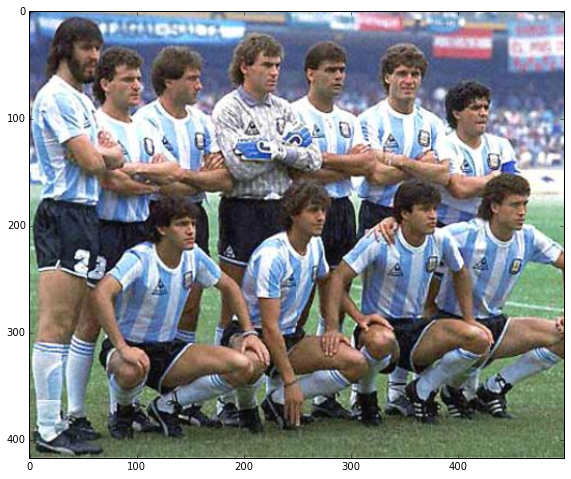

In [19]:
teams = SelectTeams(conn)
print(teams[0])
plt.imshow(teams[0].pic1.Get())
plt.show()

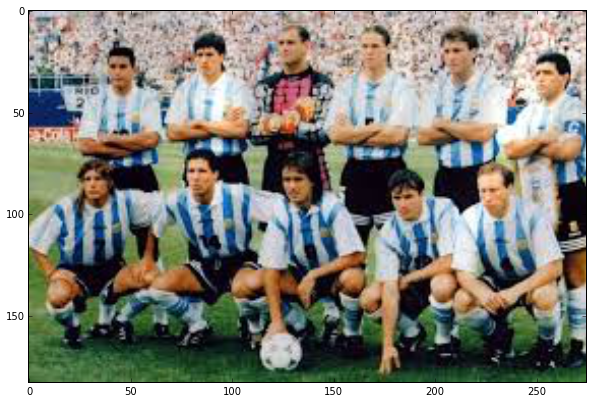

Team {
    name: team2
    id: 2
    wins: 2
    loses: 2
    pic1: ArrayInfo{avg: 120.2447, std: 74.2968, dtype:      uint8, shape: (183, 275, 3)}
    nplayers: 3
}


In [20]:
plt.imshow(teams[1].pic1.Get())
plt.show()
print(teams[1])

In [21]:
%%timeit -n 1
for i in np.arange(100):
    SelectTeams(conn)

1 loops, best of 3: 3.58 s per loop


In [22]:
%%timeit -n 1
for i in np.arange(1):
    SelectTeams(conn=conn, load=True)

The slowest run took 4.49 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 2.83 s per loop


#### UI for players

In [23]:
def SelectPlayers(conn, where = "", load=False):

    sql = """
select unique player_id 
from v_teams natural join v_players
"""
    if where != "":
        sql += "where %s" % where
        
    try:
        cursor = conn.cursor()
        cursor.execute(sql)
        records = cursor.fetchall()

    except odb.DatabaseError, exc:
        print(exc)

    finally:
        cursor.close()
        
    players = [Player(conn, record[0]) for record in records]
    if load:
        for player in playerss: player.Load()
            
    return players

In [24]:
players = SelectPlayers(conn, where='team_wins > 3')
print(players) 

[Player {
    name: t1p1
    team: team1
    id: 1
    goals: 7
    starts: 12
    image1: ArrayInfo{avg: 108.5904, std: 43.8245, dtype: not loaded, shape:    not loaded}
    image2: ArrayInfo{avg: 155.9964, std: 72.8447, dtype: not loaded, shape:    not loaded}
    image3: ArrayInfo{avg: 142.0293, std: 52.1584, dtype: not loaded, shape:    not loaded}
}, Player {
    name: t2p3
    team: team2
    id: 6
    goals: 0
    starts: 1
    image1: ArrayInfo{avg: 108.4533, std: 43.8026, dtype: not loaded, shape:    not loaded}
    image2: ArrayInfo{avg: 155.2245, std: 73.4005, dtype: not loaded, shape:    not loaded}
    image3: ArrayInfo{avg: 141.6174, std: 52.3178, dtype: not loaded, shape:    not loaded}
}, Player {
    name: t1p2
    team: team1
    id: 2
    goals: 0
    starts: 2
    image1: ArrayInfo{avg: 108.4242, std: 43.7371, dtype: not loaded, shape:    not loaded}
    image2: ArrayInfo{avg: 155.2595, std: 73.3658, dtype: not loaded, shape:    not loaded}
    image3: ArrayInfo{avg

In [25]:
players = SelectPlayers(conn, where='team_wins < 3')
print(players) 

[Player {
    name: t1p1
    team: team1
    id: 1
    goals: 7
    starts: 12
    image1: ArrayInfo{avg: 108.5904, std: 43.8245, dtype: not loaded, shape:    not loaded}
    image2: ArrayInfo{avg: 155.9964, std: 72.8447, dtype: not loaded, shape:    not loaded}
    image3: ArrayInfo{avg: 142.0293, std: 52.1584, dtype: not loaded, shape:    not loaded}
}, Player {
    name: t2p3
    team: team2
    id: 6
    goals: 0
    starts: 1
    image1: ArrayInfo{avg: 108.4533, std: 43.8026, dtype: not loaded, shape:    not loaded}
    image2: ArrayInfo{avg: 155.2245, std: 73.4005, dtype: not loaded, shape:    not loaded}
    image3: ArrayInfo{avg: 141.6174, std: 52.3178, dtype: not loaded, shape:    not loaded}
}, Player {
    name: t1p2
    team: team1
    id: 2
    goals: 0
    starts: 2
    image1: ArrayInfo{avg: 108.4242, std: 43.7371, dtype: not loaded, shape:    not loaded}
    image2: ArrayInfo{avg: 155.2595, std: 73.3658, dtype: not loaded, shape:    not loaded}
    image3: ArrayInfo{avg

In [26]:
players = SelectPlayers(conn, where='team_wins > 0 and player_goals > 10')
print(players) 

[Player {
    name: t1p3
    team: team1
    id: 3
    goals: 11
    starts: 5
    image1: ArrayInfo{avg: 108.4238, std: 43.7412, dtype: not loaded, shape:    not loaded}
    image2: ArrayInfo{avg: 155.2408, std: 73.3722, dtype: not loaded, shape:    not loaded}
    image3: ArrayInfo{avg: 141.7350, std: 52.3219, dtype: not loaded, shape:    not loaded}
}]


In [27]:
%%timeit -n 1
for i in np.arange(100):
    SelectPlayers(conn)

1 loops, best of 3: 2.56 s per loop


In [28]:
%%timeit -n 1
for i in np.arange(1):
    SelectTeams(conn=conn, load=True)

1 loops, best of 3: 2.23 s per loop


#### Close Connection

In [29]:
conn.close()